# AGN Catalog Toolbox (ACT) Encapsulated Testing

This is an example notebook showing the AGN Catalog Toolbox Testing code (written by Chris) in action.

In [1]:
import ACTTestingEncapsulation as actt
import ACTLiterature as actl 

import numpy as np
from matplotlib import pyplot as plt
import os

from scipy import interpolate

# Set the redshift of interest here.
redshift = 0.25

The variables we wish to test are listed in arrays for easy repeated access.

In [2]:
# Variations
variations = [7]
variable_name = r"$lambda$"
iterations = len(variations)



Next we create the class, and we call the approprate member functions to read in the data, assign the variables we want and then return the plotting data. Much of the best behaviour is encapsulated by the default arguments, so some parameters do not need to be called. Running this section can take some time.

Note that calling the member function to load in the multidark data expects a file in a subfolder '/BigData/' that is named 'MD_<redshift>.npy, in with the columns x, y, z, scale at accretion, mass at accretion, and mvir.

In [3]:
# Create the master class.
obj = actt.AGNCatalog()
obj.set_z(redshift)

# Load in the MultiDark Haloes.
obj.load_dm_catalog(path_big_data="/data/cm1n17/MultiDark/npyData/")
obj.assign_stellar_mass()
obj.assign_black_hole_mass()

Loading Dark Matter Catalog
Loading Halo Catalogue
Found file: MD_0.248.npy
dtypes found:  [('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('id', '<i8'), ('upid', '<i8'), ('mvir', '<f4'), ('Acc_Scale', '<f4'), ('Macc', '<f4')]
    Sorting list w.r.t. upId
    copying all 113755840 elements with up_id = -1
    sorting remaining list list w.r.t. main id
    copying remaining 17277532 elements
Assigning Stellar Mass
Scatter is a thing, valued at 0.001
Assigning Black Hole Mass


### Example of catalog cut - reduce volume

In [4]:

limit = 600 # Mpc/h
flag = (obj.main_catalog['x'] < limit) * (obj.main_catalog['y'] < limit) * (obj.main_catalog['z'] < limit)

obj.main_catalog = obj.main_catalog[flag]
obj.volume = (limit/obj.h)**3



In [5]:
# Loop to support variations in parameters
for i in range(iterations):
    obj.assign_duty_cycle("Schulze")
    
    obj.assign_luminosity(parameter1=0.08, parameter2=-0.3) # Lambda Shape? # alpha Normalization
    #obj.assign_obscuration()
    
    #obj.get_wp()
    # We then compute the bias
    #obj.get_bias()
    #obj.get_hod(centrals=False, Obscuration="Obscured")
    #obj.get_hod(centrals=False, Obscuration="Unobscured")

Assigning Duty Cycle, using Schulze's method
Warning - we have requested redshift 0.25 - Selecting file Schulze_0.1.csv as it is closest
Warning - we have requested redshift 0.25 - Selecting file Schulze_0.1.csv as it is closest
GetCorrectFile: Schulze_0.1.csv
Found Schulze file: ./Data/DutyCycles/Schulze_0.1.csv
[2.18713260e-04 2.33234685e-01 2.33234685e-01 ... 2.33234685e-01
 2.33234685e-01 2.33234685e-01]
Assigning Luminosity


### XLF

Warning - we have requested redshift 0.25 - Selecting file Miyaji2015_z0.1.txt as it is closest
RMS: 3.2810739752923634 $lambda$ = 7


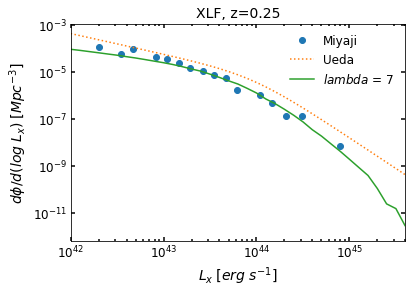

In [6]:
# Plot of the XLF 

plt.figure()#figsize=(16, 10), dpi= 80)


XLF = actl.XLFData(redshift)

mXLF_data = XLF.get_miyaji2015()
plt.plot(mXLF_data.x, mXLF_data.y, 'o', label = "Miyaji")

# XLF Data
uXLF_data = XLF.get_ueda14(np.arange(42, 46, 0.1))
plt.plot(uXLF_data.x, uXLF_data.y, ':', label = "Ueda")

#i = 5

for i in range(iterations):
    label = r"{} = {}".format(variable_name, variations[i])
    #label = "Mock Catalog"
    plt.plot(10**obj.XLF_plottingData[i].x, 10**obj.XLF_plottingData[i].y, label = label)

    #RMS comparison to Udea
    xto_data = interpolate.interp1d(obj.XLF_plottingData[i].x, obj.XLF_plottingData[i].y, bounds_error=False, fill_value=((obj.XLF_plottingData[i].y)[0], (obj.XLF_plottingData[i].y)[-1]))
    xto_comparison = interpolate.interp1d(np.log10(uXLF_data.x), np.log10(uXLF_data.y), bounds_error=False, fill_value=( ( np.log10(uXLF_data.y[0]), np.log10(uXLF_data.y[-1]) ) ) ) 
    
    x_range = np.linspace(42, 44.5)
                                           
    rms = np.sqrt( np.sum( ( (xto_data(x_range) - xto_comparison(x_range) )**2 ) ) )  
    print("RMS:", rms,  r"{} = {}".format(variable_name, variations[i]) )



# Plotting
plt.xlabel(r'$L_x\;[erg\;s^{-1}]$',fontsize = 14)
plt.ylabel(r'$d\phi /d(log\;L_x)\;[Mpc^{-3}]$', fontsize = 14)
plt.title(r'XLF, z={}'.format(redshift), fontsize = 14)
plt.xlim((1e42, 4e45))
plt.loglog()
plt.tick_params(which='major', right=True, top=True, direction='in', length=4, width=1.5, labelsize = 12)
plt.tick_params(which='minor', right=True, top=True, direction='in', length=2, width=1.5)
plt.minorticks_on()
plt.legend(frameon=False, fontsize = 12)
plt.savefig("./Plots/XLF_Geo_z0.png", dpi=400)
plt.show()

### Eddington Ratio Distribution

Warning - we have requested redshift 0.25 - Selecting file Aird2018z0.1.csv as it is closest
RMS: 1.9458239944798807 $lambda$ = 7


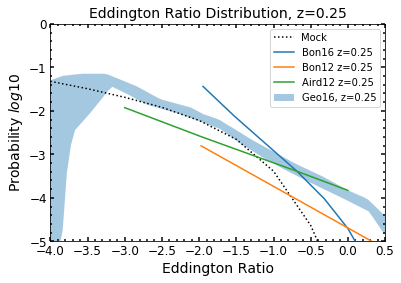

In [7]:
# Plot the Eddington ratio distribution

plt.figure()#figsize=(16, 10), dpi= 80)

EddData = actl.EddingtonDistributionData(redshift)
#plt.plot(EddData.Geo.x, EddData.Geo.y, label = "Geo")

plt.fill_between(EddData.Geo.x, EddData.Geo.yu, EddData.Geo.yd, alpha=0.4, label = "Geo16, z={}".format(EddData.Geo.z) )

for i in range(iterations):
    label =  r"{} = {}".format(variable_name, variations[i])
    label = "Mock"
    plt.plot(obj.Edd_plottingData[i].x, obj.Edd_plottingData[i].y, 'k:', label = label)
    # RMS
    xto_data = interpolate.interp1d(obj.Edd_plottingData[i].x, obj.Edd_plottingData[i].y, bounds_error=False, fill_value=((obj.Edd_plottingData[i].y)[0], (obj.Edd_plottingData[i].y)[-1]))
    
    xto_top = interpolate.interp1d(EddData.Geo.x, EddData.Geo.yu)
    xto_bottom = interpolate.interp1d(EddData.Geo.x, EddData.Geo.yd)
    
    x_range = np.linspace(-3.5, -0.5)
    
    sample_data = xto_data(x_range)
    sample_u = xto_top(x_range)
    sample_d = xto_bottom(x_range)

    res = np.zeros_like(x_range)
    
    res[sample_data > sample_u] = sample_data[sample_data > sample_u] - sample_u[sample_data > sample_u]
    res[sample_data < sample_d] = sample_data[sample_data < sample_d] - sample_d[sample_data < sample_d]
    rms =  np.sqrt(np.sum(res**2))
    print("RMS:", rms, r"{} = {}".format(variable_name, variations[i]) )
    
plt.plot(EddData.Bon16.x, EddData.Bon16.y, label = "Bon16 z={}".format(EddData.Bon16.z)) 
plt.plot(EddData.Bon12.x, EddData.Bon12.y, label = "Bon12 z={}".format(EddData.Bon12.z))
plt.plot(EddData.Aird12.x, EddData.Aird12.y, label = "Aird12 z={}".format(EddData.Aird12.z) )

#eddbin = np.arange(-4, 1., 0.5)
#probSche = EddData.AirdDist(eddbin)
#plt.plot(eddbin, probSche, label = "Aird ?(analytic)")

plt.title(r'Eddington Ratio Distribution, z={}'.format(redshift), fontsize = 14)
          #U=Schulze,$\alpha$=-0.25, z=0', fontname = 'Times New Roman')
plt.xlabel("Eddington Ratio", fontsize = 14)
plt.ylabel("Probability $log10$", fontsize = 14)
plt.xlim((-4, 0.5))
plt.ylim((-5, 0))

plt.tick_params(which='major', right=True, top=True, direction='in', length=4, width=1.5, labelsize = 12)
plt.tick_params(which='minor', right=True, top=True, direction='in', length=2, width=1.5)
plt.minorticks_on()

plt.legend()

plt.savefig("./Plots/ERD_Geo_z0.png", dpi=400)


plt.show()


In [8]:
count = 0

while count < 10:
    count += 1
    os.system('spd-say "your program has finished"')

### WP

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

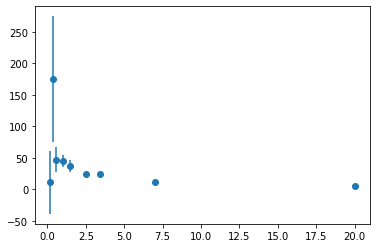

In [9]:
plt.figure()

wp_data = actl.WPData(redshift)

for i in range(iterations):
    try:
        label = r"{} = {}".format(variable_name, variations[i])
        label = "Mock"                           
        plt.plot(obj.WP_plottingData[i].x, obj.WP_plottingData[i].y, 'k:', label=label)
        if i == 4:
            break
    except:
        pass
    
plt.errorbar(wp_data.r_Koutoulidis, wp_data.wp_Koutoulidis,\
                yerr = wp_data.wp_Koutoulidis_e, fmt='o', label = "Koutoulidis Data, z~1")

plt.plot(obj.wpbins, wp_data.k_power_law(obj.wpbins), label = "Koutoulidis Fit, z~1")
plt.title(r'wp, z=1', fontname = 'Times New Roman', fontsize = 14)
#plt.title(r'wp (obscured), z=1, $\alpha$=-0.4', fontname = 'Times New Roman')    
plt.xlabel(r'$r_p$ $Mpc/h$', fontsize = 14)
plt.ylabel(r'$w(r_p)$', fontsize = 14)

plt.tick_params(which='major', right=True, top=True, direction='in', length=4, width=1.5, labelsize = 12)
plt.tick_params(which='minor', right=True, top=True, direction='in', length=2, width=1.5)
plt.minorticks_on()

plt.legend()
plt.loglog()
plt.savefig("./Plots/clustering_Geo_z0.png", dpi=400)

plt.show()



### Bias

In [ ]:
plt.figure()

for i in range(iterations):
    plt.plot(obj.bias_plottingData[i].x, obj.bias_plottingData[i].y, ':', label = r"{} = {}".format(variable_name, variations[i]))
    
plt.xlabel("Stellar Mass")
plt.ylabel("Bias")
plt.legend()
plt.show()

### HOD

In [ ]:

plt.figure()

labels = ["Obscured", "Unobscured"]

for i in range(2):
    plt.plot(10**obj.HOD_plottingData[i].x, obj.HOD_plottingData[i].y, ':', label=labels[i])
plt.xlabel(r"Halo Mass $M_\odot$", fontsize=14)
plt.ylabel("HOD", fontsize=14)
plt.tick_params(which='major', right=True, top=True, direction='in', length=4, width=1.5, labelsize = 12)
plt.tick_params(which='minor', right=True, top=True, direction='in', length=2, width=1.5)
plt.title("HOD, z = 0.1", fontsize = 14)
plt.minorticks_on()
plt.loglog()
plt.legend()
plt.show()

In [ ]:
obj.HOD_plottingData